# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie (last updated: *06/08/2023*)
***
**Description:**
Notebook to interpret the best trained models on the Jores et al (2021) dataset.
***

In [1]:
# General imports
import os
import sys
import glob
import torch
import numpy as np
import torch.nn.functional as F

# EUGENe imports and settings
import eugene as eu
from eugene import preprocess as pp
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/jores21"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp

# For illustrator editing
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"PyTorch version: {torch.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Eugene version: 0.0.8
SeqData version: 0.0.1
PyTorch version: 2.0.0


# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [102]:
# Load in the preprcoessed test data with predictions
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "leaf_test_predictions.zarr"))
sdata_proto = sd.open_zarr(os.path.join(settings.output_dir, "proto", "proto_test_predictions.zarr"))
sdata_combined = sd.open_zarr(os.path.join(settings.output_dir, "combined", "combined_test_predictions.zarr"))

# Load the best model

In [103]:
# Load them all but will choose one
leaf_model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "leaf_trial_3", "checkpoints", "*"))[0]
leaf_model_arch = models.load_config(config_path="hybrid.yaml")
leaf_model = models.SequenceModule.load_from_checkpoint(leaf_model_file, arch=leaf_model_arch.arch)
proto_model_file = glob.glob(os.path.join(settings.logging_dir, "jores21_cnn", "proto_trial_3", "checkpoints", "*"))[0]
proto_model_arch = models.load_config(config_path="jores21_cnn.yaml")
proto_model = models.SequenceModule.load_from_checkpoint(proto_model_file, arch=proto_model_arch.arch)
combined_model_file = glob.glob(os.path.join(settings.logging_dir, "deepstarr", "combined_trial_5", "checkpoints", "*"))[0]
combined_model_arch = models.load_config(config_path="deepstarr.yaml")
combined_model = models.SequenceModule.load_from_checkpoint(combined_model_file, arch=combined_model_arch.arch)

[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 5


In [119]:
# Choose which model you want to intepret
name = "proto"
arch = "jores21_cnn"
trial = 5
model = proto_model
sdata = sdata_proto

# Feature attribution

In [105]:
# Run DeepLift with a simple all 0s reference
method = "DeepLift"
interpret.attribute_sdata(
    model,
    sdata,
    method=method,
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/60 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

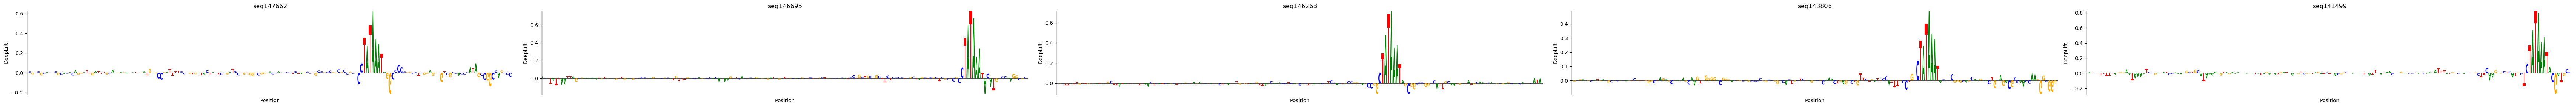

In [106]:
top5 = sdata[f"{arch}_trial_{trial}_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:5].index
top5_idx = np.argsort(sdata[f"{arch}_trial_{trial}_enrichment_predictions"].values)[::-1][:5]
ids = sdata["id"].values[top5_idx]
pl.multiseq_track(
    sdata,
    seq_ids=ids,
    attrs_keys = f"{method}_attrs",
    ylabs=method,
    height=3,
    width=70,
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_feature_attr.pdf")
)

# Filter viz

In [120]:
if arch == "jores21_cnn":
    model.to("cuda")
    layer_name = "arch.biconv"
    seqs = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").to_numpy()
    seqs_torch = torch.tensor(seqs, dtype=torch.float32).to(model.device)
    kernel = models.get_layer(model, f"{layer_name}.kernels")[0].to(model.device)
    bias = models.get_layer(model, f"{layer_name}.biases")[0].to(model.device)
    activations = F.conv1d(seqs_torch, kernel, stride=1, padding="same")
    activations = torch.add(activations.transpose(1, 2), bias).transpose(1, 2)
    activations = activations.detach().cpu().numpy()
    padding = 6
    transforms=None
    kernel_size = 13
else:
    if arch == "deepstarr":
        kernel_size = 7
        padding = 3
        layer_name = "arch.conv1d_tower.layers.2"
    else:
        padding = 0
        kernel_size = 13
        layer_name = "arch.conv1d_tower.layers.1"
    activations = None
    seqs = None
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
kernel_size, padding, transforms, layer_name

(13, 6, None, 'arch.biconv')

In [122]:
# Generate pfms from filters
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_key="ohe_seq",
    layer_name=layer_name,
    kernel_size=13,
    activations=activations,
    seqs=seqs,
    num_filters=256,
    padding=padding,
    num_seqlets=100,
    transforms=transforms,
)

Using provided activations of shape (7595, 256, 170) and sequences of shape (7595, 4, 170).


Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

Activators shape: (256, 100, 4, 13)


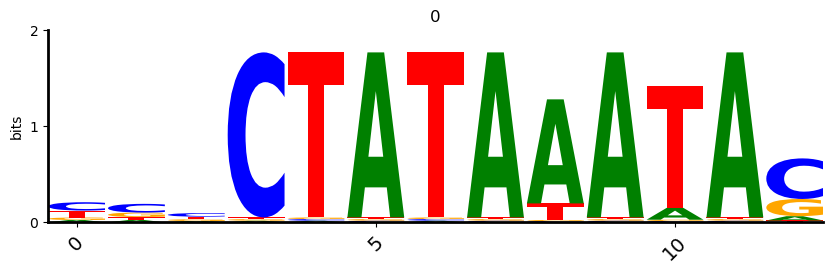

In [123]:
# Visualize a filter of choice
pl.filter_viz(
    sdata,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
)

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256


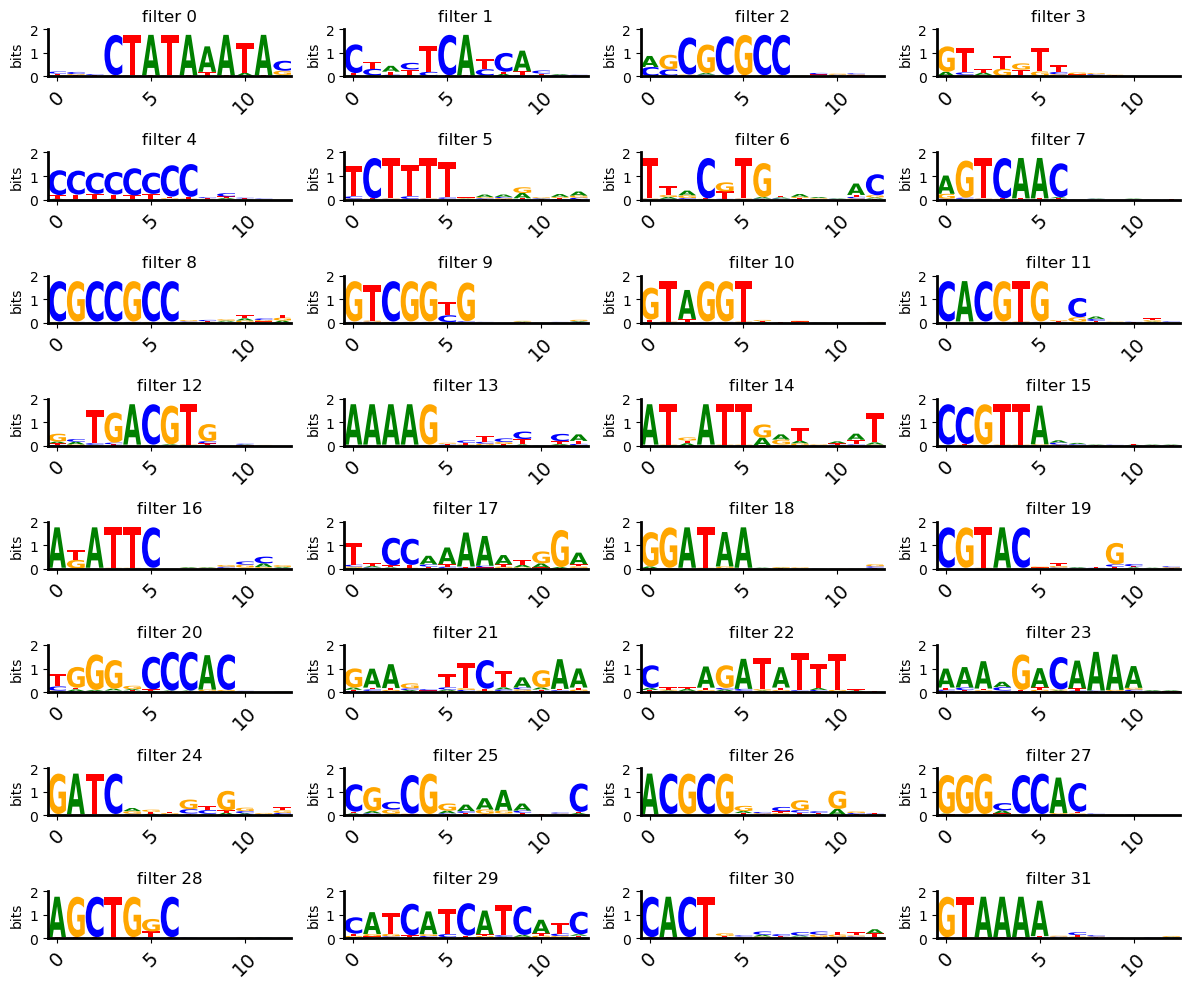

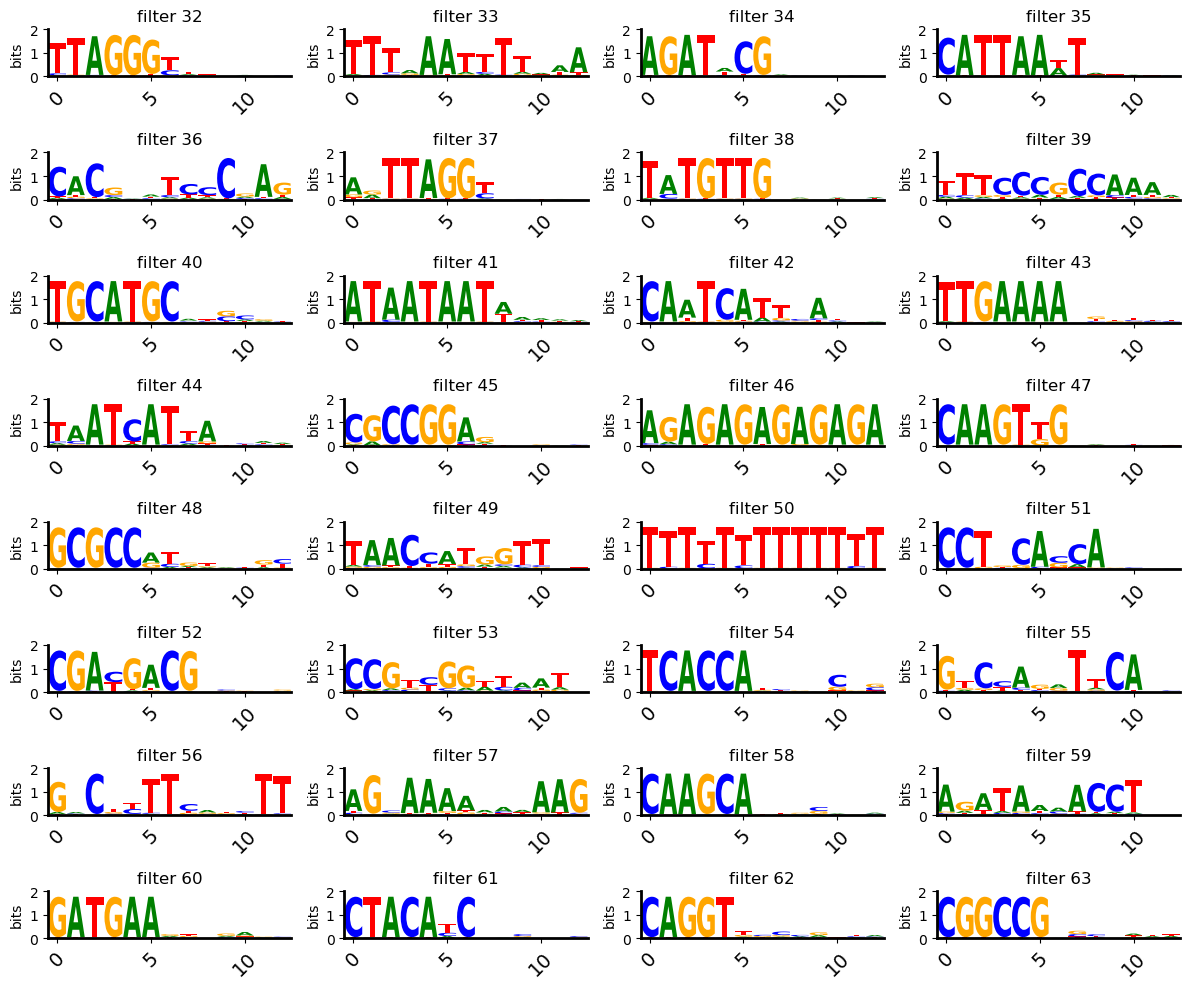

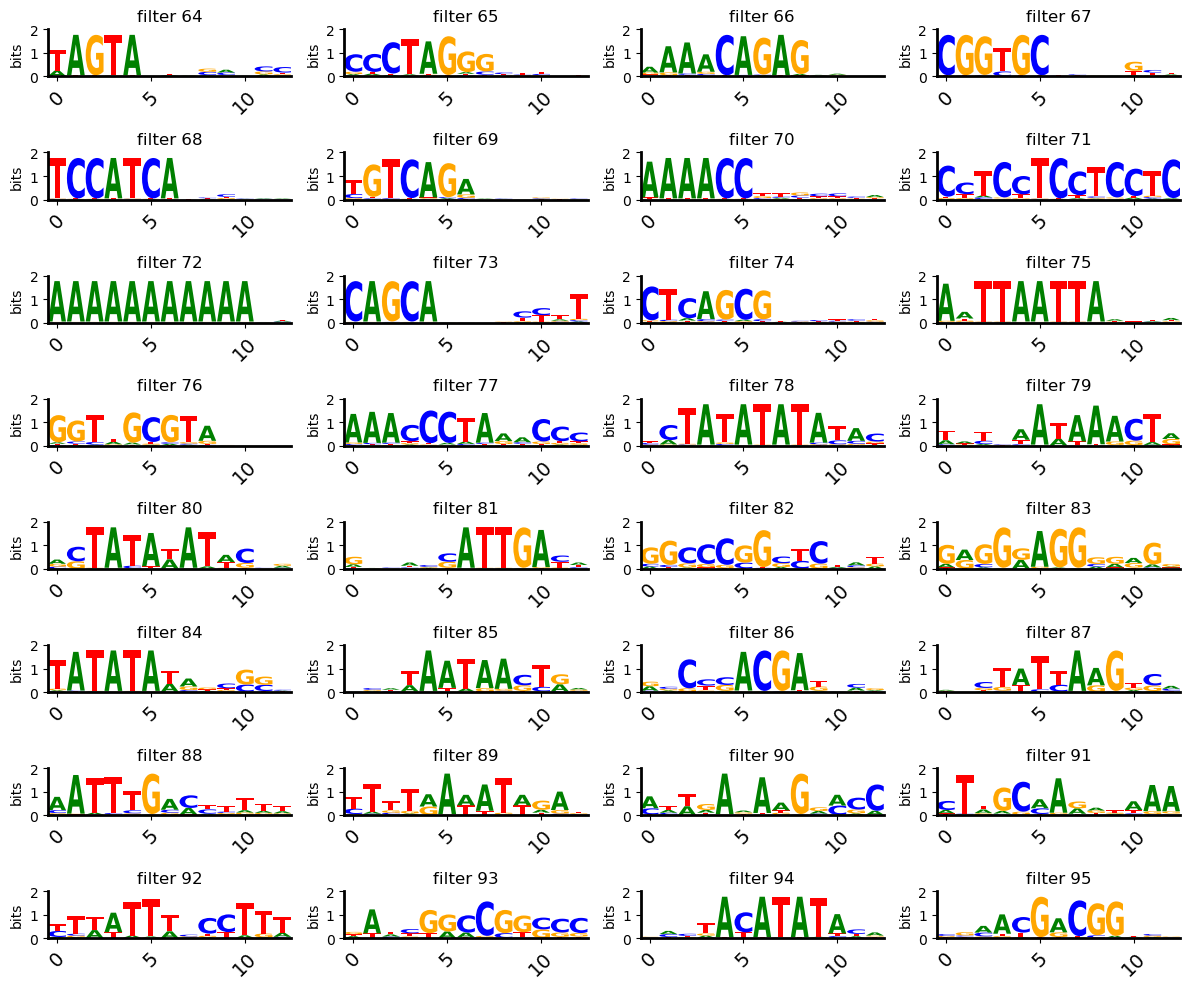

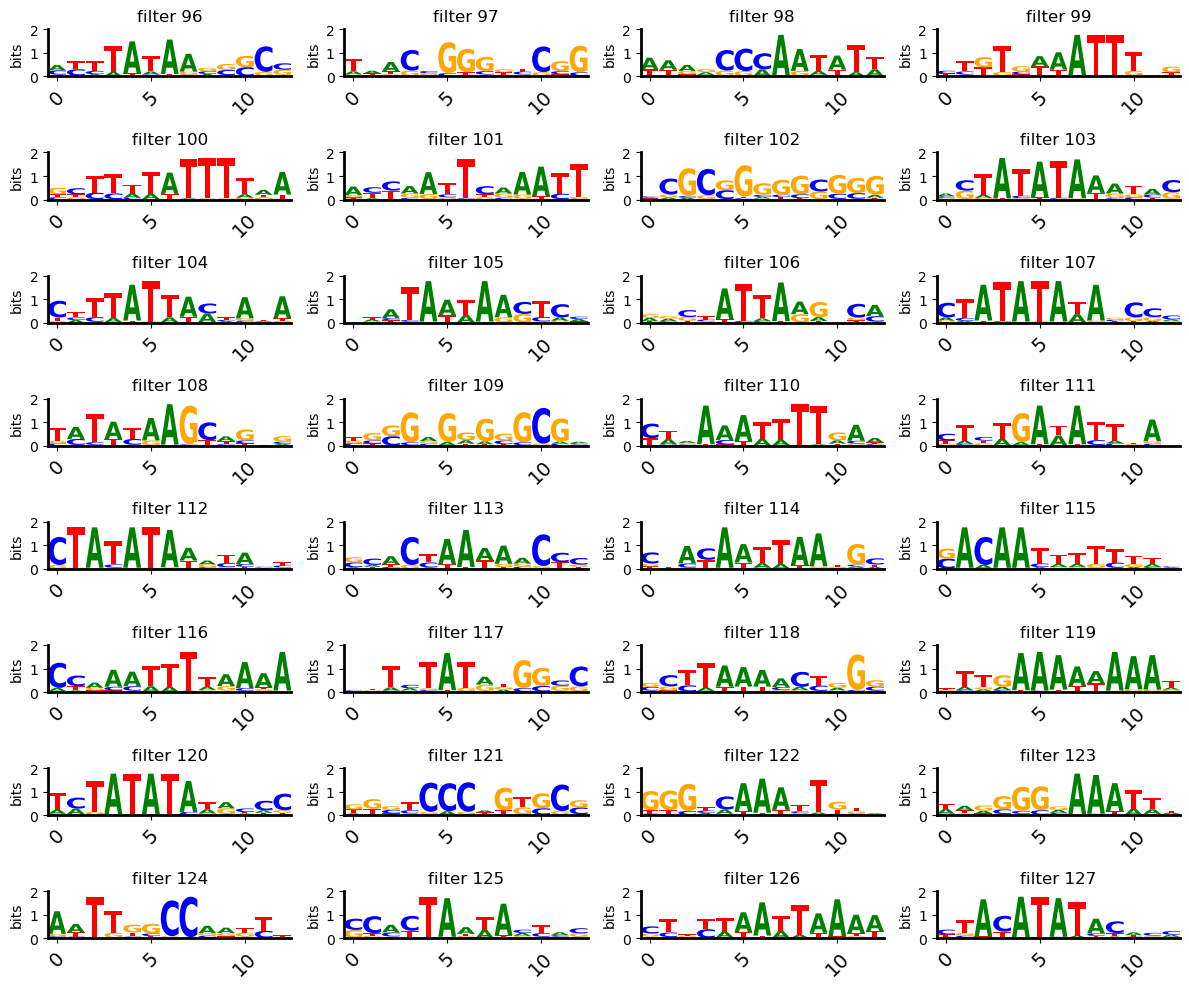

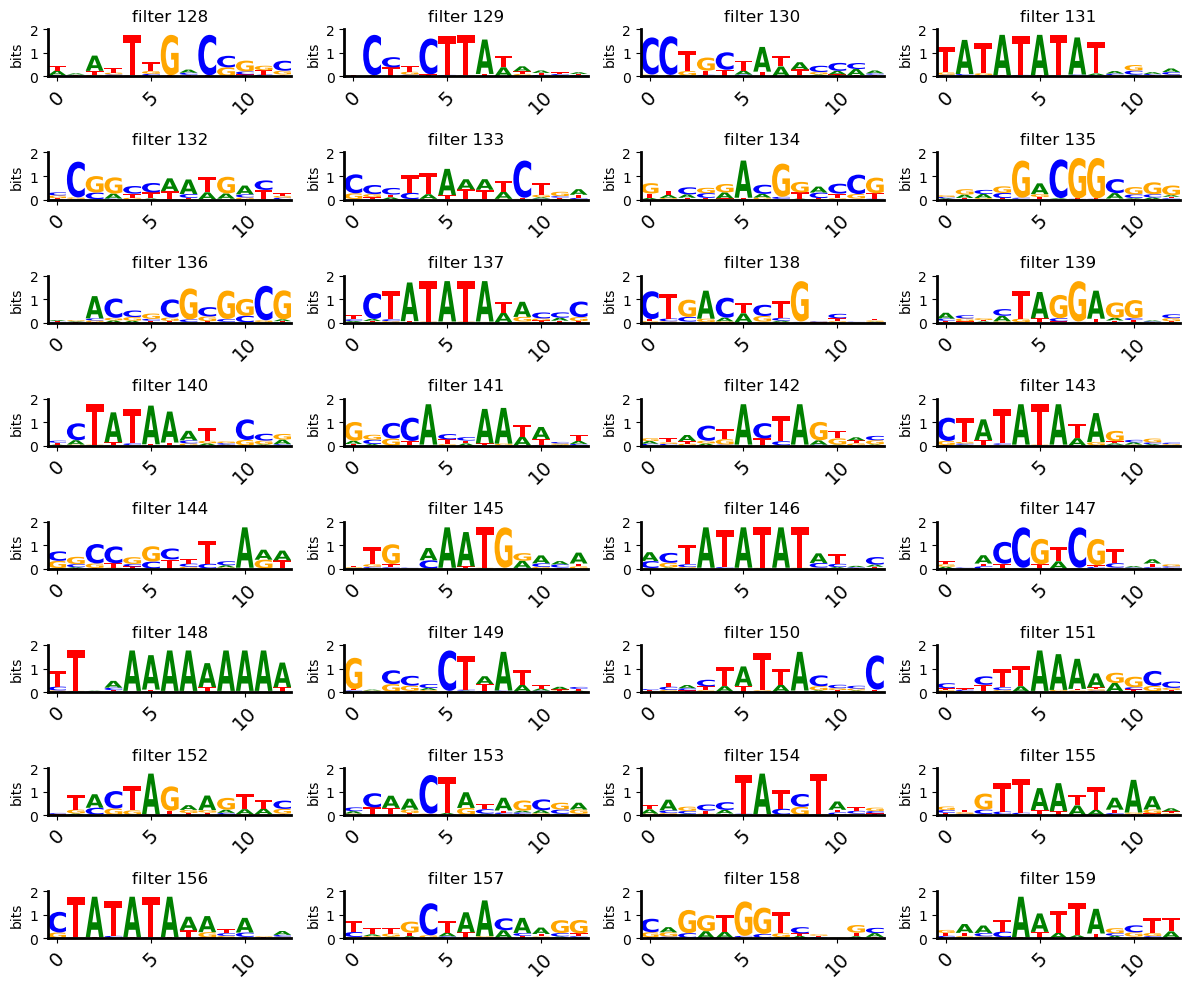

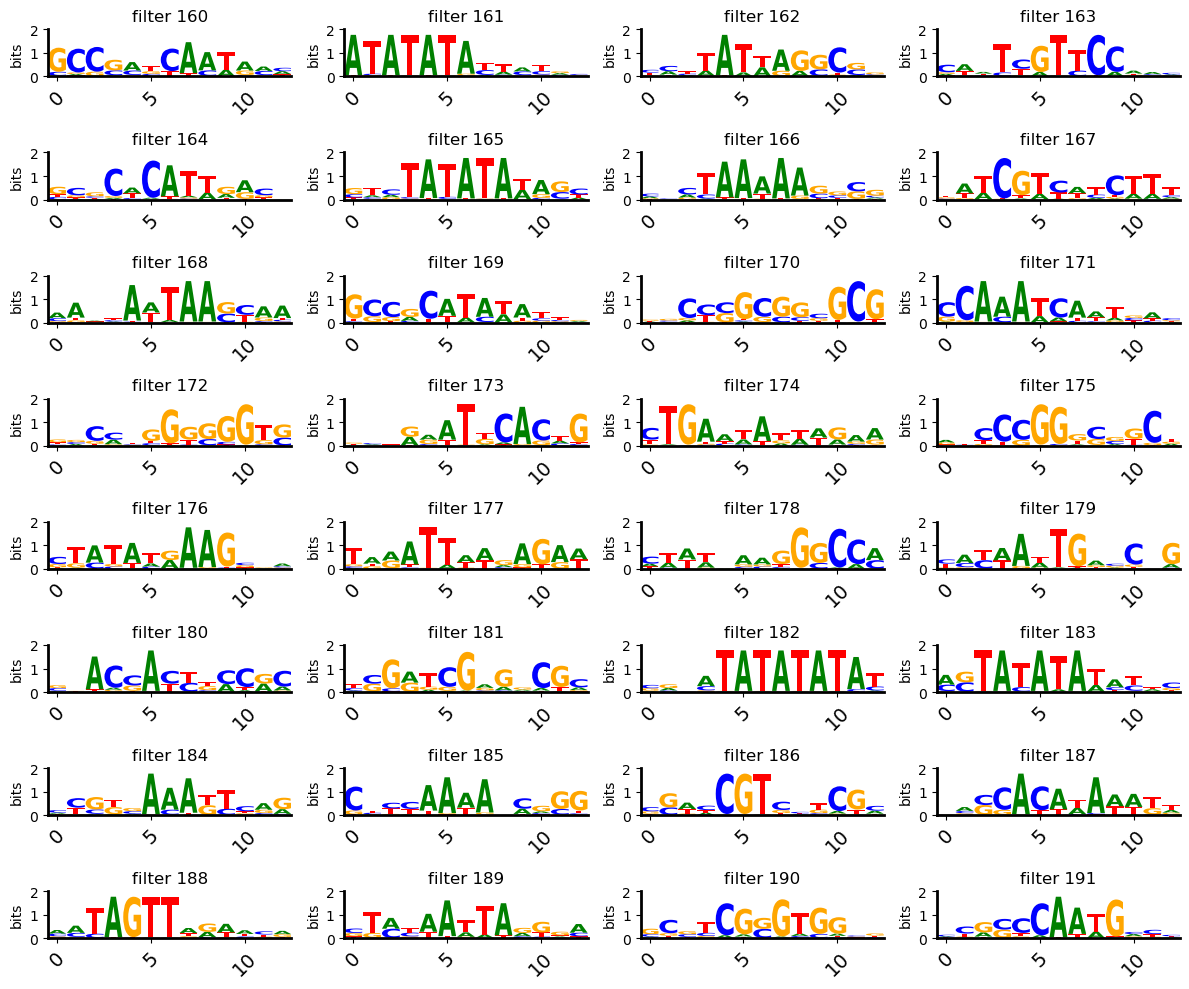

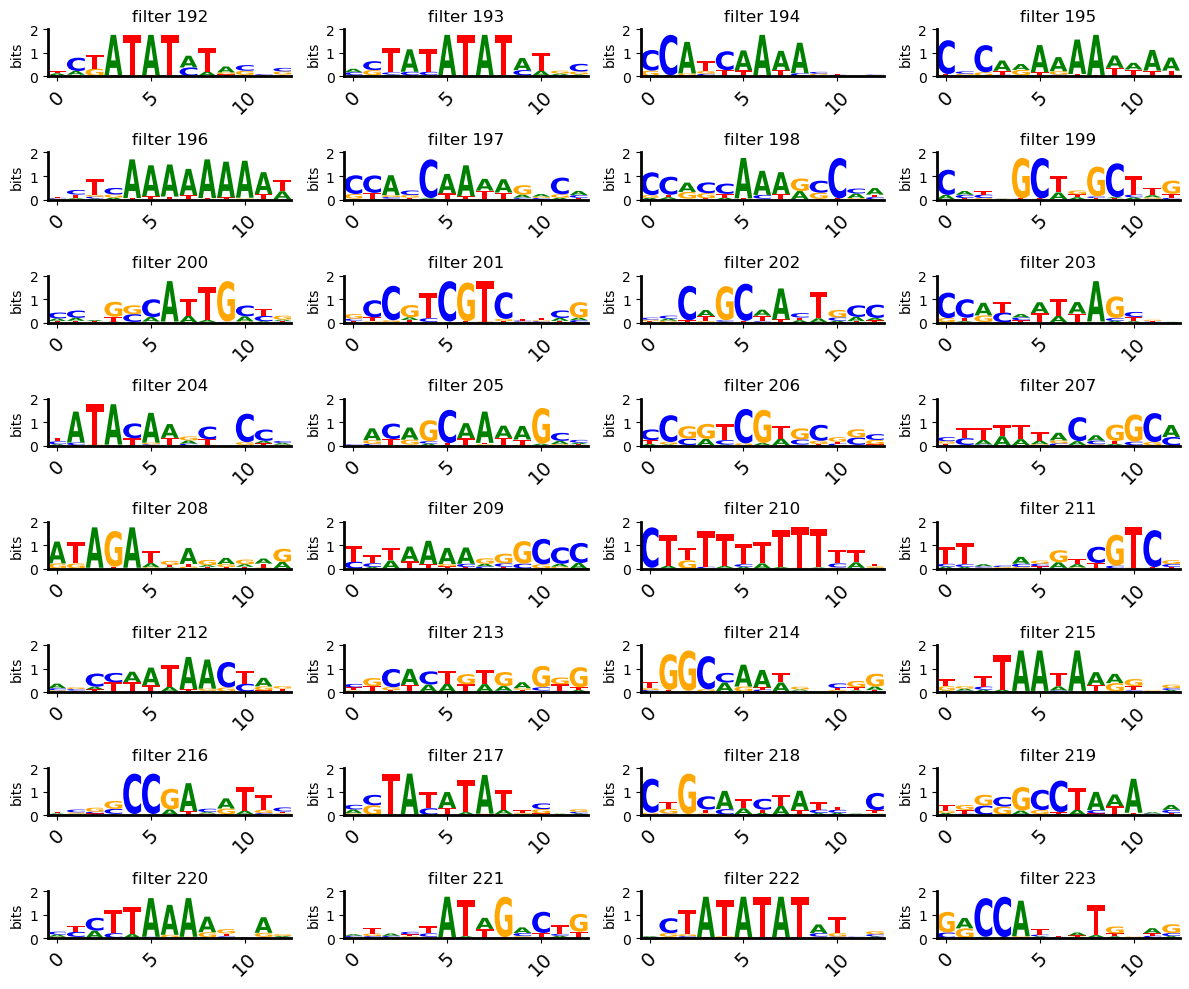

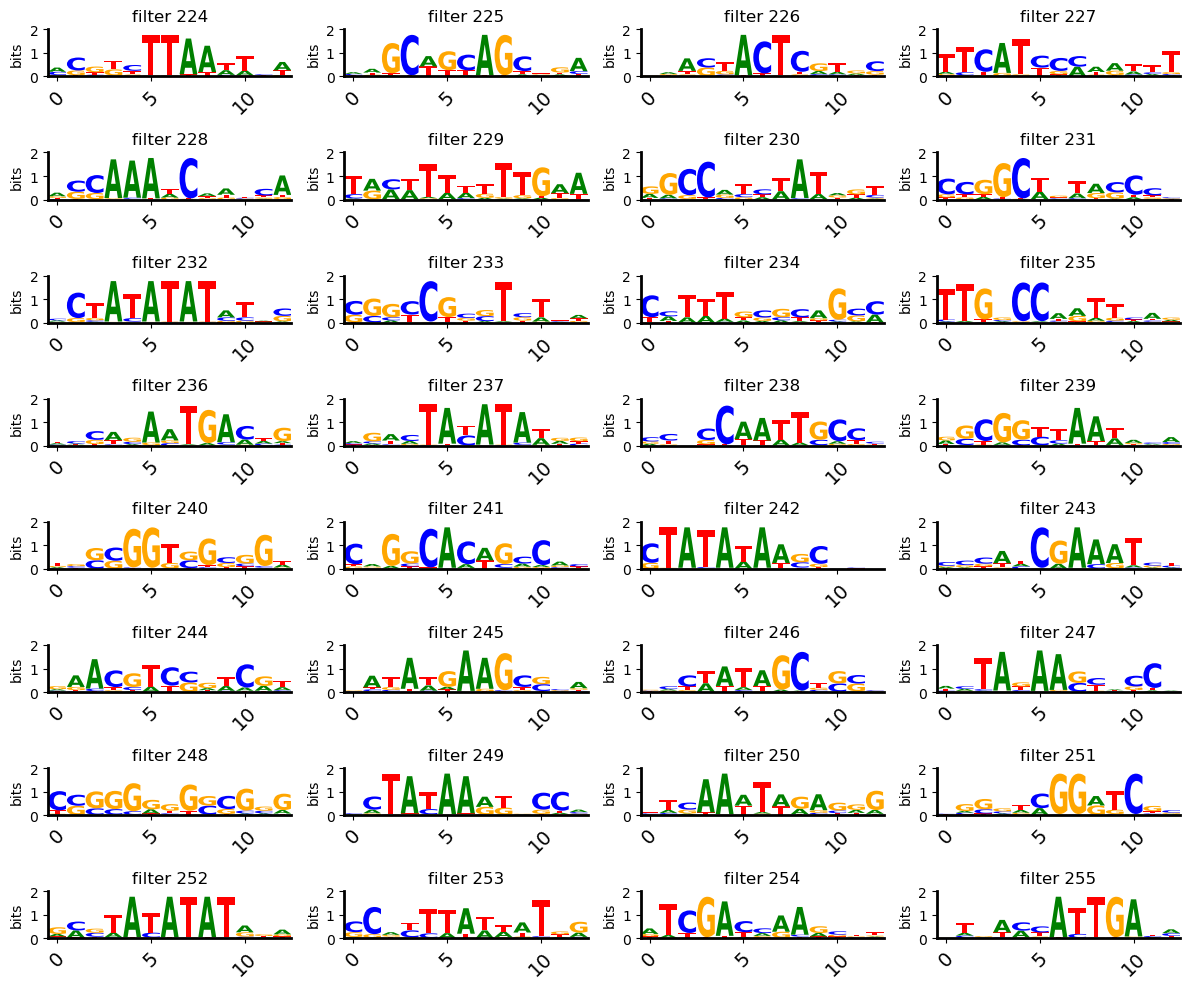

In [124]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    pl.multifilter_viz(
        sdata,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{layer_name}_pfms",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(settings.figure_dir, name, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [91]:
# Save all the filter pfms from above as meme format for submission to TomTom
interpret.filters_to_meme_sdata(
    sdata,
    filters_key=f"{layer_name}_pfms",
    output_dir=os.path.join(settings.output_dir, name),
    filename=f"{name}_best_model_filters.meme"
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/leaf
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/leaf/leaf_best_model_filters.meme


In [125]:
# Save the predictions and interpretations to zarr
sd.to_zarr(sdata, os.path.join(settings.output_dir, name, f"{name}_test_predictions_and_interpretations.zarr"), load_first=True, mode="w")

# *in silico* evolution 

In [37]:
# Load in sequences that were evolved in the published paper
sdata_evolve = sd.read_table(
    name="seq",
    tables=os.path.join(settings.dataset_dir, "promoters_for_evolution.tsv"),
    out=os.path.join(settings.dataset_dir, "promoters_for_evolution.zarr"),
    seq_col="sequence",
    fixed_length=False,
    batch_size=310,
    overwrite=True
)
pp.ohe_seqs_sdata(sdata_evolve)

310it [00:00, 3180.73it/s]


In [38]:
# Evolve them using the best model across 10 rounds
interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

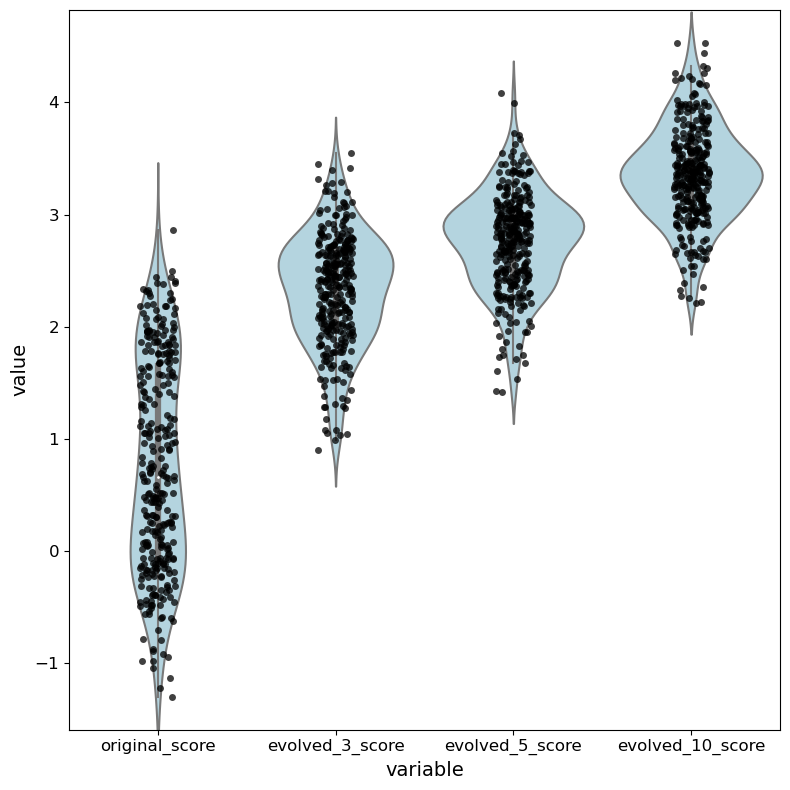

In [39]:
# Plot the distribution of scores at different rounds of evolution
pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_evolution_summary.pdf")
)

In [40]:
# Write out the evolved sequences and their scores (along with the original sequences)
sd.to_zarr(sdata_evolve, os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"), load_first=True, mode="w")

# Positional GIA

In [41]:
# Reread in the evolved sequences and their scores
sdata_evolve = sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"))

In [42]:
# Read in the motif
motif_set = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = motif_set["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus

# Generate some baseline sequences
zero_pfm = np.zeros(pfm.shape)
rand_pfm = sp.ohe(sp.random_seq(pfm.shape[0]), alphabet=sp.ALPHABETS["DNA"])
shuffled_pfm = sp.ohe(sp.k_shuffle(consensus, k=1).tobytes().decode(), alphabet=sp.ALPHABETS["DNA"])
zero_pfm.shape, rand_pfm.shape, shuffled_pfm.shape

((16, 4), (16, 4), (16, 4))

In [43]:
# Slide the TATA motif across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=pfm,
    feature_name=feat_name,
    encoding="onehot",
    store_key=f"slide_{feat_name}",
)

# Slide a random seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=rand_pfm,
    feature_name="random",
    encoding="onehot",
    store_key=f"slide_random",
)

# Slide a zero ohe seq across the sequences 
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=zero_pfm,
    feature_name="zero",
    encoding="onehot",
    store_key=f"slide_zero",
)

# Slide a TATA shuffled ohe seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=shuffled_pfm,
    feature_name="shuffled",
    encoding="onehot",
    store_key=f"slide_shuffled",
)   

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

In [44]:
# Check the average percentage increase across the sequences and positions
mean_original = sdata_evolve["original_score"].values.mean()
avg_increase = np.mean(np.subtract(sdata_evolve["slide_TATA"].values, np.expand_dims(sdata_evolve["original_score"].values, axis=1)), axis=1)
(avg_increase.mean()/mean_original).mean()*100

135.4344606399536

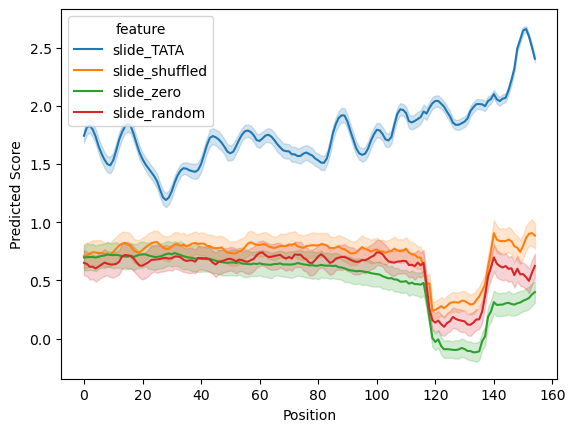

In [45]:
# Generate a line plot
pl.positional_gia_plot(
    sdata_evolve,
    keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    id_key="name",
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_feature_implant_TATA.pdf")
)

In [46]:
# Save the evolved sequences  with the TATA implanted scores as well
sd.to_zarr(sdata_evolve, os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences_with_TATA_implant.zarr"), load_first=True, mode="w")

# DONE!

---

# Scratch

In [17]:
sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_test_predictions_and_interpretations.zarr"))

<xarray.Dataset>
Dimensions:                                     (_sequence: 7154, _ohe: 4,
                                                 length: 170,
                                                 _num_kernels: 256,
                                                 _kernel_size: 13)
Dimensions without coordinates: _sequence, _ohe, length, _num_kernels,
                                _kernel_size
Data variables: (12/41)
    DeepLift_attrs                              (_sequence, _ohe, length) float32 dask.array<chunksize=(1789, 1, 85), meta=np.ndarray>
    GC                                          (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    UTR                                         (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfms             (_num_kernels, _kernel_size, _ohe) float32 dask.array<chunksize=(256, 13, 4), meta=np.ndarray>
    barcodes                                    (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    batch                                       <U4 ...
    ...                                          ...
    set                                         (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    sp                                          (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    start                                       (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    strand                                      (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    target                                      (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    type                                        (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
Attributes:
    max_jitter:  0

In [19]:
sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"))

<xarray.Dataset>
Dimensions:           (_sequence: 310, _ohe: 4, length: 170)
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/15)
    evolved_10_score  (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_1_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_2_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_3_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_4_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_5_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    ...                ...
    evolved_9_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_seqs      (_sequence, _ohe, length) float64 dask.array<chunksize=(155, 2, 170), meta=np.ndarray>
    name              (_sequence) object dask.array<chunksize=(310,), meta=np.ndarray>
    ohe_seq           (_sequence, length, _ohe) uint8 dask.array<chunksize=(310, 170, 4), meta=np.ndarray>
    original_score    (_sequence) float32 dask.array<chunksize=(310,), meta=np.ndarray>
    seq               (_sequence) |S170 dask.array<chunksize=(310,), meta=np.ndarray>